## Project documentation
### Metal Surface Defects Classification
This project is written in an area of XRay defect detection. All images taken using XRay are grayscale images. They do not have similar patterns to some well-known pretrained models' patterns, thus it is necessary to train such a model from scratch. 
### Data description
The dataset was downloaded from Kaggle (https://www.kaggle.com/fantacher/neu-metal-surface-defects-data). It contains six kinds of typical surface defects of the hot-rolled steel strip:
1. Crazing
2. Inclusion
3. Patches
4. Pitted surface
5. Rolled-in scale
6. Scratches. 
The database consists of 1,800 grayscale images, which are devided into train, valid and test datasets.

In [839]:
#!g1.1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
import os
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split
from PIL import Image
from sklearn.metrics import accuracy_score

In [791]:
# #!g1.1
# %rm -r ./data/test/.ipynb_checkpoints
# %rm -r ./data/val/0/.ipynb_checkpoints
# %rm -r ./data/val/1/.ipynb_checkpoints
# %rm -r ./data/test/.ipynb_checkpoints
# %rm -r ./data/val/3/.ipynb_checkpoints
# %rm -r ./data/val/4/.ipynb_checkpoints
# %rm -r ./data/val/5/.ipynb_checkpoints

In [840]:
#!g1.1
train_data_path = "./data/train/"
valid_data_path = "./data/valid/"
test_data_path = "./data/test/"

transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(64),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
valid_data = torchvision.datasets.ImageFolder(root=valid_data_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)

valid_data

Dataset ImageFolder
    Number of datapoints: 72
    Root location: ./data/valid/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

In [841]:
#!g1.1
batch_size = 64
train_data_loader = DataLoader(train_data, batch_size=batch_size)
valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

In [842]:
#!g1.1
class CNNNet(nn.Module):
    def __init__(self, num_classes = 6):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=2), 
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=5, padding=2),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential (
            nn.Dropout(),
            nn.Linear(16*6*6, 2048), 
            nn.ReLU(inplace=True),
            nn.Linear(2048, 6)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [843]:
#!g1.1
modelCnn = CNNNet()

In [844]:
#!g1.1

optimizer = optim.AdamW(modelCnn.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

modelCnn.to(device)
train_losses = []
val_losses = []

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=60, device=device):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item()
        training_loss /= len(train_loader)
        train_losses.append(training_loss)

        model.eval()
        num_correct = 0
        num_examples = 0

        for batch in val_loader:
            inputs, target = batch
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = loss_fn(output, target)
            valid_loss += loss.data.item()
    #             print(torch.max(nn.functional.softmax(output, dim=1), dim=1))
    #             print(torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target))
            correct = torch.eq(torch.argmax(nn.functional.softmax(output, dim=1), dim=1), target)

            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)
        val_losses.append(valid_loss)
        print("Epoch: {}, Training Loss {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}".format(epoch, training_loss, valid_loss, 
                                                                                                     num_correct / num_examples))
        if valid_loss < 0.4 and training_loss < 0.5:
            break 

In [845]:
#!g1.1
train(modelCnn, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, valid_data_loader)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Training Loss 2.50, Validation Loss: 1.83, accuracy = 0.17
Epoch: 1, Training Loss 1.83, Validation Loss: 1.83, accuracy = 0.24
Epoch: 2, Training Loss 1.80, Validation Loss: 1.82, accuracy = 0.14
Epoch: 3, Training Loss 1.80, Validation Loss: 1.81, accuracy = 0.11
Epoch: 4, Training Loss 1.80, Validation Loss: 1.81, accuracy = 0.11
Epoch: 5, Training Loss 1.79, Validation Loss: 1.81, accuracy = 0.14
Epoch: 6, Training Loss 1.79, Validation Loss: 1.80, accuracy = 0.17
Epoch: 7, Training Loss 1.79, Validation Loss: 1.80, accuracy = 0.25
Epoch: 8, Training Loss 1.78, Validation Loss: 1.80, accuracy = 0.24
Epoch: 9, Training Loss 1.77, Validation Loss: 1.77, accuracy = 0.22
Epoch: 10, Training Loss 1.82, Validation Loss: 1.73, accuracy = 0.17
Epoch: 11, Training Loss 1.81, Validation Loss: 1.79, accuracy = 0.39
Epoch: 12, Training Loss 1.75, Validation Loss: 1.74, accuracy = 0.38
Epoch: 13, Training Loss 1.71, Validation Loss: 1.68, accuracy = 0.32
Epoch: 14, Training Loss 1.62,

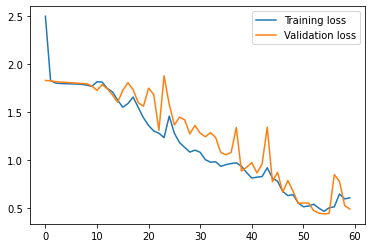

In [846]:
#!g1.1
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [847]:
#!g1.1
pred = []
y_test = []
for batch in test_data_loader:
    inputs, target = batch
    inputs = inputs.to(device)
    target = target.to(device)
    output = modelCnn(inputs)
    softmax = torch.exp(output)
    predictions = torch.argmax(softmax, dim=1)
    # accuracy on validation set
    pred += predictions.tolist()
    y_test += target.tolist()
acc = accuracy_score(pred, y_test)
print(acc)

0.7638888888888888


In [848]:
#!g1.1
PATH = "modelCnn.pth"
torch.save(modelCnn.state_dict(), PATH)

In [752]:
#!g1.1
pred = []
y_test = []
for batch in test_data_loader:
    inputs, target = batch
    inputs = inputs.to(device)
    target = target.to(device)
    output = modelCnn(inputs)
    softmax = torch.exp(output)
    predictions = torch.argmax(softmax, dim=1)
    # accuracy on validation set
    pred += predictions.tolist()
    y_test += target.tolist()
acc = accuracy_score(pred, y_test)
print(acc)

0.7916666666666666


In [875]:
# #!g1.1
# model = CNNNet()
# model.load_state_dict(torch.load("modelCnn.pth", map_location="cpu"))
# model.eval()

In [874]:
# #!g1.1
# number_to_class = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

# transforms = torchvision.transforms.Compose([
# #     torchvision.transforms.Resize(64),
#     torchvision.transforms.Grayscale(),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# for cl in number_to_class:
    
#     data_dir = "data/test/" + cl
#     for filename in os.listdir(data_dir):
#         test_data_path = data_dir + "/" + filename
#         pil_img = Image.open(test_data_path)
#         img = transforms(pil_img)
#         probabilities = model(img.unsqueeze(0))

#         softmax = torch.exp(probabilities)
#         predictions = torch.argmax(softmax, dim=1)
#         number_to_class = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
#         index = torch.argsort(probabilities, dim=1)[0]
#         probabilities = probabilities.tolist()[0]
#         predictions = {
#                   "class1":number_to_class[index[5]],
#                   "class2":number_to_class[index[4]],
#                   "class3":number_to_class[index[3]],
#                   "prob1":probabilities[index[5]],
#                   "prob2":probabilities[index[4]],
#                   "prob3":probabilities[index[3]],
#               }

In [873]:
#!g1.1

In [ ]:
#!g1.1
